In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from scipy.signal import welch

import sys
sys.path.append('../../../tool_code/python_tool_code/function/') # "~~/tool_code/plot/" (상대 경로)
sys.path.append('../../../tool_code/python_tool_code/frequency_analysis/frequency_func')

from DataPlot import Data_Load_Plot, Result_Plot, Result_Plot2, Result_Plot_paper, Loss_Plot
from Scaling import time_scaling, time_inv_scaling
from FFT_func import FFT
from Welch_func import Welch

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


Contaminated_data.shape: (1000, 4000)
Clean_data.shape: (1000, 4000)


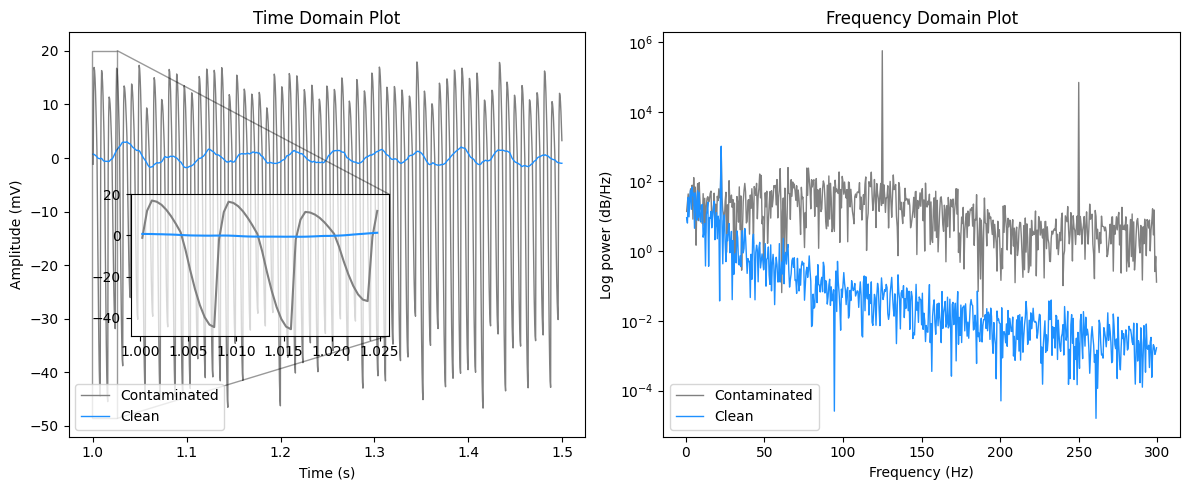

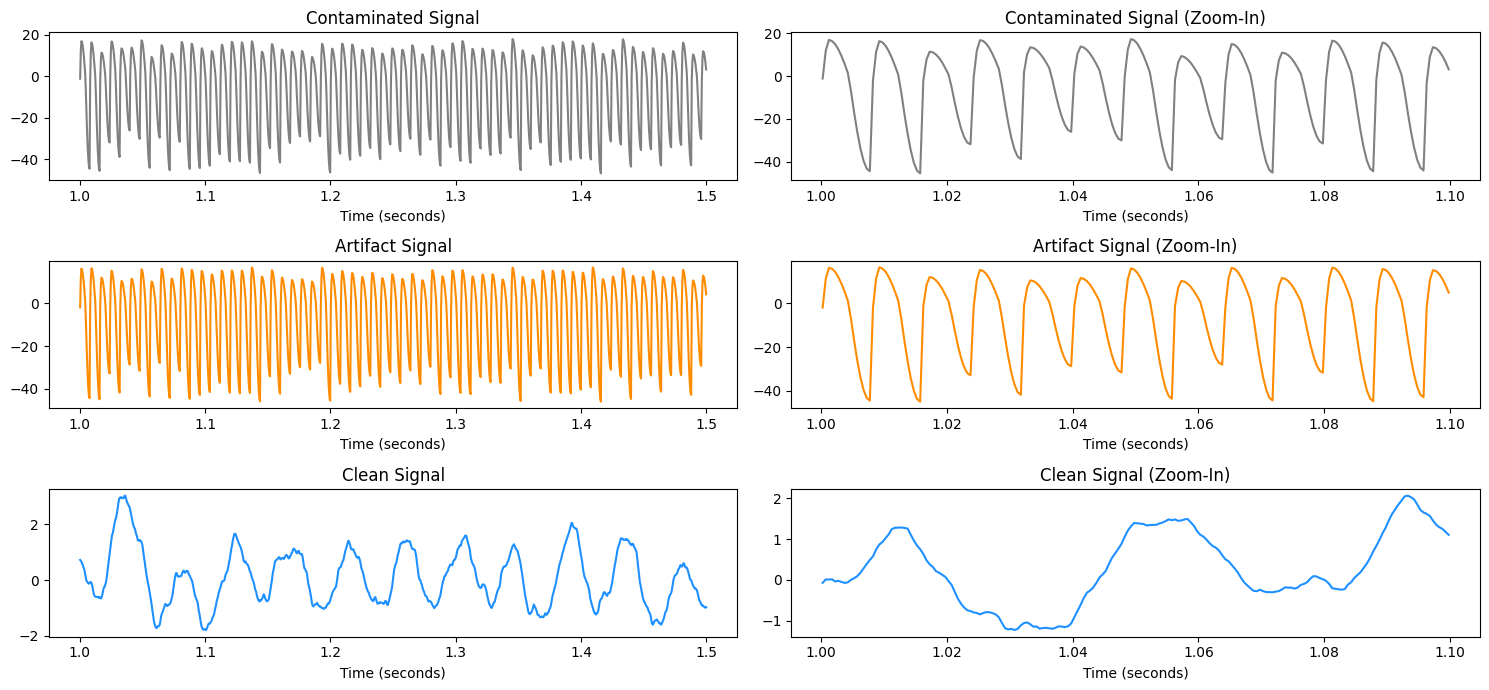

In [2]:
# 데이터 load & plot
datapath='../../../data/synthetic_data/'

Contaminated_data, Clean_data, Artifact_data = Data_Load_Plot(datapath)

In [3]:
# Data Standard Scaling
X, y, scaler_x, scaler_y = time_scaling(Contaminated_data, Clean_data, standard='x')

X: (1000, 4000)
y: (1000, 4000)


In [4]:
# Data preprocessing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train shape: {}, y_train shape: {}".format(X_train.shape, y_train.shape)) # x : B x T, y : B x T
print("X_test shape: {}, y_test shape: {}".format(X_test.shape, y_test.shape))

# 차원 추가 (CNN은 두번째 차원 추가)
X_train = X_train.reshape(X_train.shape[0], 1, 4000) # B x 1 x T
X_test = X_test.reshape(X_test.shape[0], 1, 4000)

print("unsqueezed X_train shape: {}, y_train shape: {}".format(X_train.shape, y_train.shape)) # x : B x 1 x T, y : B x T
print("unsqueezed X_test shape: {}, y_test shape: {}".format(X_test.shape, y_test.shape))

train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

X_train shape: (800, 4000), y_train shape: (800, 4000)
X_test shape: (200, 4000), y_test shape: (200, 4000)
unsqueezed X_train shape: (800, 1, 4000), y_train shape: (800, 4000)
unsqueezed X_test shape: (200, 1, 4000), y_test shape: (200, 4000)


In [5]:
# 모델 정의
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv1d(1, 16, 3, padding=1),
            nn.GELU(),
            nn.Conv1d(16, 32, 3, padding=1),
            nn.BatchNorm1d(32),
            nn.GELU(),
            nn.Conv1d(32, 16, 3, padding=1),
            nn.GELU(),
            nn.Conv1d(16, 1, 3, padding=1)
        )
        
        self.drop = nn.Dropout1d(0.25)

    def forward(self, x): # x : B x 1 x T
        x = self.layer1(x)
        x = x.squeeze(1) # x : B x T
        return x

model = CNN().to(device)
print(model)

CNN(
  (layer1): Sequential(
    (0): Conv1d(1, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): GELU(approximate='none')
    (2): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): GELU(approximate='none')
    (5): Conv1d(32, 16, kernel_size=(3,), stride=(1,), padding=(1,))
    (6): GELU(approximate='none')
    (7): Conv1d(16, 1, kernel_size=(3,), stride=(1,), padding=(1,))
  )
  (drop): Dropout1d(p=0.25, inplace=False)
)


In [6]:
# 모델 훈련
learning_rate = 0.01
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

num_epochs = 200

for epoch in range(num_epochs):
    for batch in train_loader:   
        x = batch[0] # x : B x 1 x T
        y = batch[1] # y : B x T
        x, y = x.to(device), y.to(device)
        
        y_pred = model(x) # y_pred : B x T
        loss = criterion(y_pred,y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch+1)%5 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

Epoch 5/200, Loss: 0.0021295982878655195
Epoch 10/200, Loss: 0.0014870353043079376
Epoch 15/200, Loss: 0.0007188823074102402
Epoch 20/200, Loss: 0.0003131268604192883
Epoch 25/200, Loss: 0.00015249209536705166
Epoch 30/200, Loss: 0.00011641903984127566
Epoch 35/200, Loss: 0.00010974447650369257
Epoch 40/200, Loss: 0.00029405750683508813
Epoch 45/200, Loss: 0.00010091852163895965
Epoch 50/200, Loss: 9.368381870444864e-05
Epoch 55/200, Loss: 9.191392018692568e-05
Epoch 60/200, Loss: 0.0001079122957889922
Epoch 65/200, Loss: 0.0001609070022823289
Epoch 70/200, Loss: 0.00010563947580521926
Epoch 75/200, Loss: 0.00023740463075228035
Epoch 80/200, Loss: 0.00014931827899999917
Epoch 85/200, Loss: 9.086625505005941e-05
Epoch 90/200, Loss: 0.00010621504770824686
Epoch 95/200, Loss: 9.201138163916767e-05
Epoch 100/200, Loss: 5.937779860687442e-05
Epoch 105/200, Loss: 8.126253669615835e-05
Epoch 110/200, Loss: 6.39565332676284e-05
Epoch 115/200, Loss: 7.454234582837671e-05
Epoch 120/200, Loss: 0.

In [7]:
# 모델 평가
Contaminated = torch.tensor([])
Clean = torch.tensor([])
SACed = torch.tensor([])

model.eval()
with torch.no_grad():
    for batch in test_loader:
        x = batch[0] # x : B x T x 1
        y = batch[1] # y : B x T
        x, y = x.to(device), y.to(device)
        
        y_pred = model(x) # y_pred : B x T
        
        Contaminated = torch.cat((Contaminated, x.squeeze().cpu()), 0)
        SACed = torch.cat((SACed, y_pred.cpu()), 0)
        Clean = torch.cat((Clean, y.cpu()), 0)

val_loss = criterion(Clean, SACed)
print(f'Validation Loss: {val_loss.item()}')    

Validation Loss: 6.744889105902985e-05


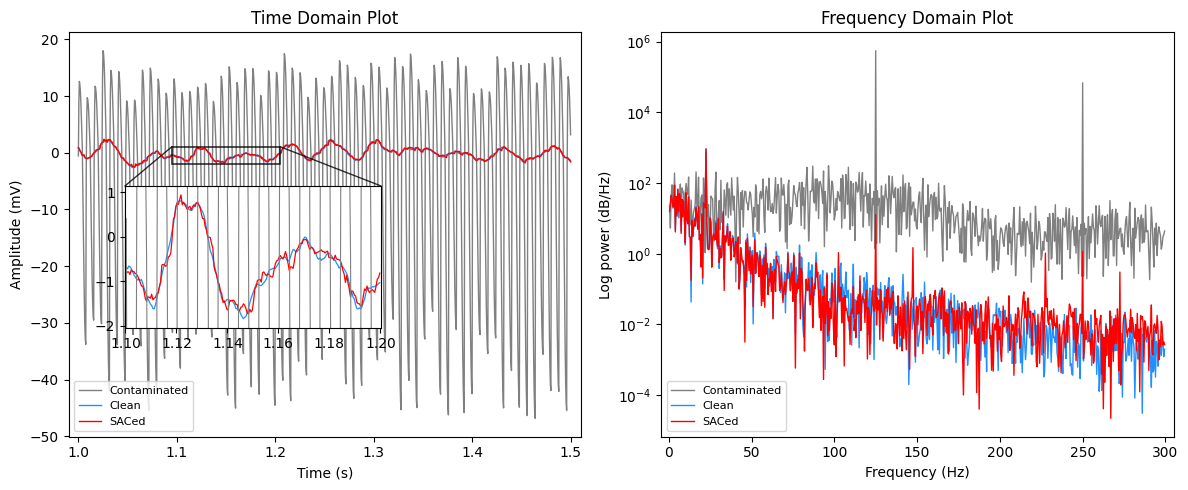

<Time Domain Error>
Mean Absolute Error: 0.1183
Mean Squared Error: 0.0233
<Frequency Domain Error>
Mean Absolute Error: 0.116
Mean Squared Error: 1.2639


In [9]:
# Inverse Scaling
Contaminated_inv_scaled, SACed_inv_scaled, Clean_inv_scaled = time_inv_scaling(Contaminated, SACed, Clean, scaler_x)

result_data = [Contaminated_inv_scaled, SACed_inv_scaled, Clean_inv_scaled]
save_path = '../../../result/output_data/'
np.save(save_path + "model_output" + ".npy", result_data)

save_path = '../../../result/CNN/'
save_title = 'CNN'

Result_Plot(Contaminated_inv_scaled, SACed_inv_scaled, Clean_inv_scaled) # inverse scaled data를 input으로 넣음

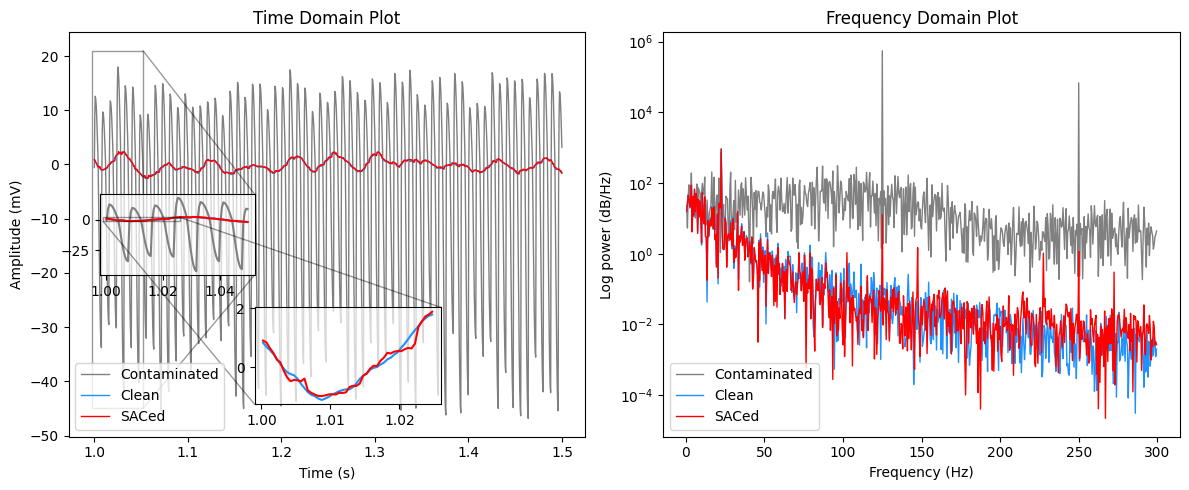

<Time Domain Error>
Mean Absolute Error: 0.1183
Mean Squared Error: 0.0233
<Frequency Domain Error>
Mean Absolute Error: 0.116
Mean Squared Error: 1.2639


In [10]:
# 결과 Plot
Result_Plot2(Contaminated_inv_scaled, SACed_inv_scaled, Clean_inv_scaled) # inverse scaled data를 input으로 넣음

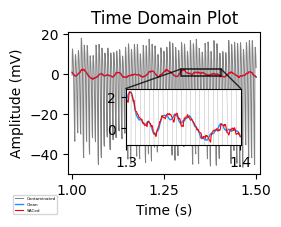

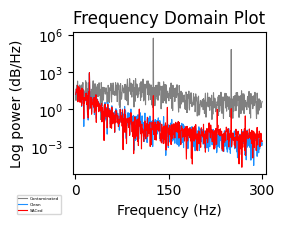

<Time Domain Error>
Mean Absolute Error: 0.1183
Mean Squared Error: 0.0233
<Frequency Domain Error>
Mean Absolute Error: 0.116
Mean Squared Error: 1.2639


In [11]:
Result_Plot_paper(Contaminated_inv_scaled, SACed_inv_scaled, Clean_inv_scaled) # inverse scaled data를 input으로 넣음